In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset

from scipy.spatial.transform import Rotation as R

import semd2d_utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset = "data/esim_data/slider/"
events = np.loadtxt(path + dataset + "events.txt")

In [3]:
# use only the specified patch of input events
patch_center = (90, 90)
patch_size = 180
events = semd2d_utils.filter_patch(events, patch_center, patch_size)

data_steps = 200 # timesteps to divide the data into
sim_steps = 200 # simulation steps
shape = (patch_size, patch_size)
t_start = events[0, 0]
duration = events[-1, 0] - events[0, 0]

In [4]:
events_conv, new_shape = flt.filter_conv(events, shape, factor=2)
shape = new_shape
events = events_conv

In [5]:
events = flt.filter_refract(events, 0.2)
events = flt.filter_time(events, 2.5, 2.7)

In [6]:
t_start = events[0, 0]
duration = events[-1, 0] - events[0, 0]

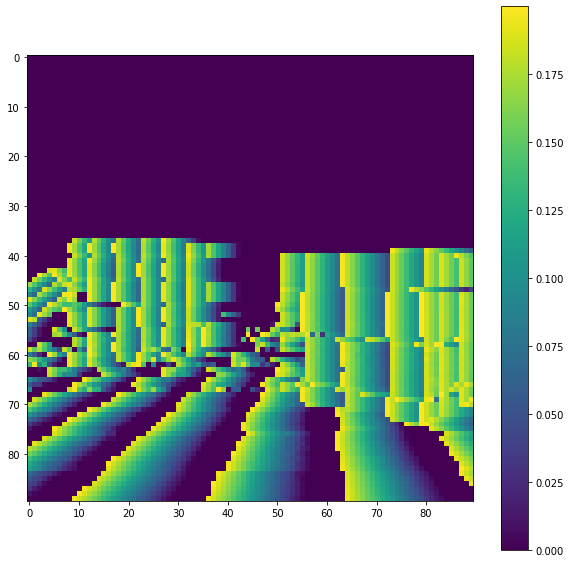

In [7]:
img = vis.events2time_surf(events[:], shape, filter_polarity=False)
plt.figure(figsize=(10, 10))
m = plt.imshow(img, interpolation="none")
plt.colorbar(m)

In [8]:
args = {
    "shape":shape,
    "conv_shape": (1,1),
    "conv_stride": (1,1),
    "thresh_conv": 0.5,
    "detector_du": 0.1,
    "tu": -57,
    "tv": 0
}
data_u, data_v, data_d = semd2d_utils.run_sim(args, events, data_steps, sim_steps)

In [9]:
# %matplotlib inline
# plt.figure(figsize=(10, 10))
# img = np.sum(data_u[:,:,0:], axis=-1)
# img_m = np.ma.masked_where(img==0, img)
# m = plt.imshow(img_m, cmap="jet")
# plt.colorbar(m)

In [10]:
# data_m = np.ma.masked_where(data_u==0, data_u)
# plt.hist(data_m.compressed(), 100);

In [11]:
data_u *= 0.01
data_v *= 0.01

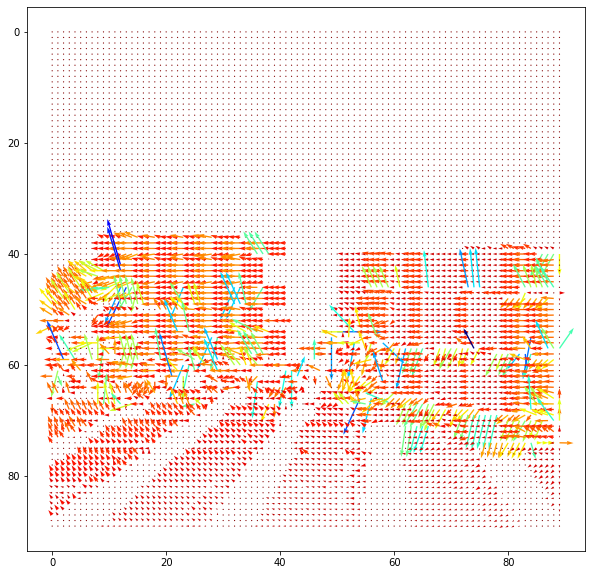

In [12]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = np.sqrt(np.square(data_u) + np.square(data_v)).sum(axis=-1)
plt.quiver(data_u.sum(axis=-1), data_v.sum(axis=-1), m, cmap="jet_r")
plt.gca().invert_yaxis()

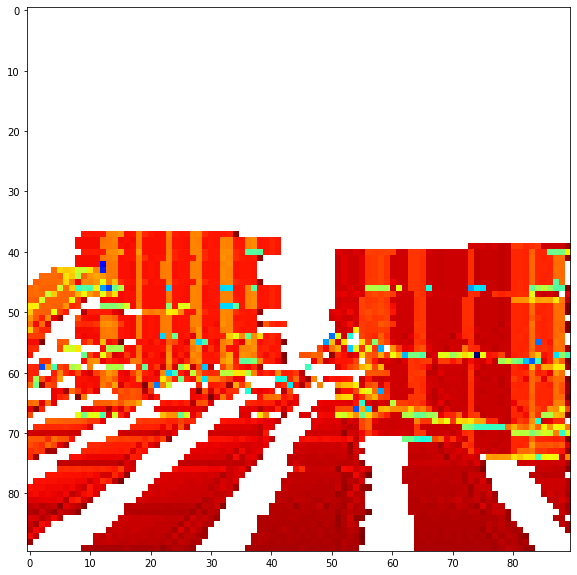

In [13]:
plt.figure(figsize=(10, 10))
m_m = np.ma.masked_where(m==0.0, m)
plt.imshow(m_m, interpolation="none", cmap="jet_r")

In [14]:
# med = flt.median_filter(m_m, 3)
# med_m = np.ma.masked_where(med==0.0, med)
# plt.figure(figsize=(10, 10))
# plt.imshow(med_m, interpolation="none", cmap="jet_r")

In [15]:
d = data_u.sum(axis=-1) * (-53) + data_v.sum(axis=-1) * 0.0

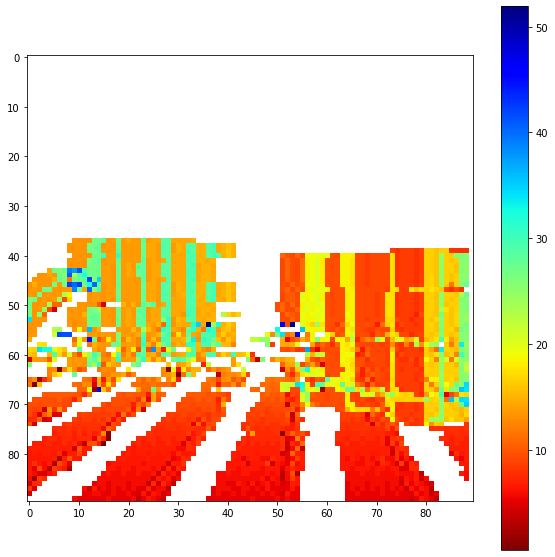

In [16]:
plt.figure(figsize=(10, 10))
d_m = np.ma.masked_where(d <= 0.0, d)
m = plt.imshow(d_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

12.92608557386528


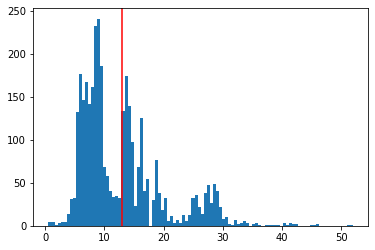

In [17]:
plt.hist(d_m.compressed(), 100);
plt.axvline(x=np.ma.mean(d_m), c="red", label="mean")
print(np.ma.mean(d_m))

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_868/2492209042.py:9: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(m)


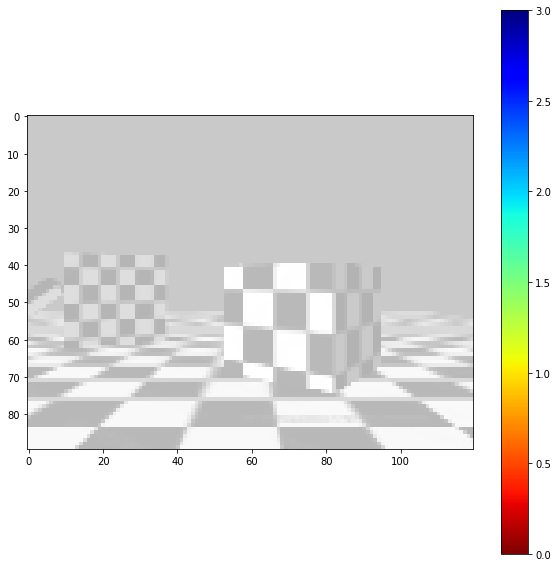

In [51]:
%matplotlib inline
t = 150
data_dn = np.divide(data_d[:,:,t:].sum(axis=-1), (data_d[:,:,t:] != 0.0).sum(axis=-1), where=(data_d[:,:,t:] != 0.0).sum(axis=-1)!=0.0)
plt.figure(figsize=(10, 10))
data_d_m = np.ma.masked_where(data_dn==0.0, data_dn) * (0.2 / sim_steps)
img_gray = plt.imread(path + dataset+ "images/frame_00000076.png")
plt.imshow(img_gray[::2, ::2], alpha=0.3, cmap="gray")
# m = plt.imshow(data_d_m, interpolation="none", cmap="jet_r", vmax=3)
plt.colorbar(m)

1.0776884879725086


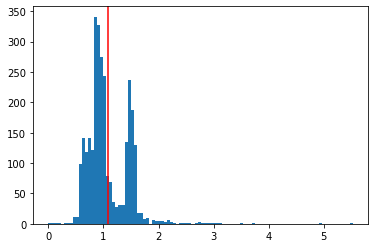

In [19]:
plt.hist(data_d_m.compressed(), 100);
plt.axvline(x=np.ma.mean(data_d_m), c="red", label="mean")
print(np.ma.mean(data_d_m))

In [20]:
data_d_time = np.zeros((data_d.shape[0], data_d.shape[1]))
for i in range(data_d.shape[-1]):
    data_d_time = np.abs(data_d[:,:,i]*(i+1) + data_d_time * (data_d[:,:,i] == 0).astype(int))

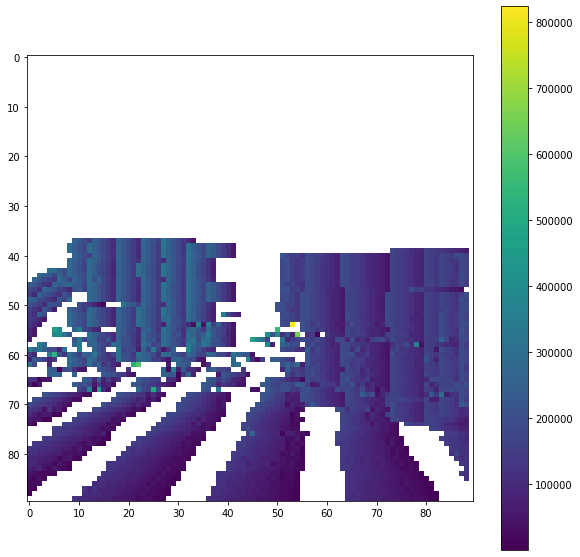

In [21]:
plt.figure(figsize=(10, 10))
img_m = np.ma.masked_where(data_d_time==0, data_d_time)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(m)

In [22]:
(data_d_time == 0.0).astype(int) * np.full(data_d_time.shape, 2.0)

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [0., 0., 2., ..., 2., 2., 2.],
       [0., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [23]:
data_d.min()

0.0

In [24]:
input_data = semd2d_utils.gen_input_data(events, shape, 100)

In [25]:
input_data.shape

(90, 90, 100)

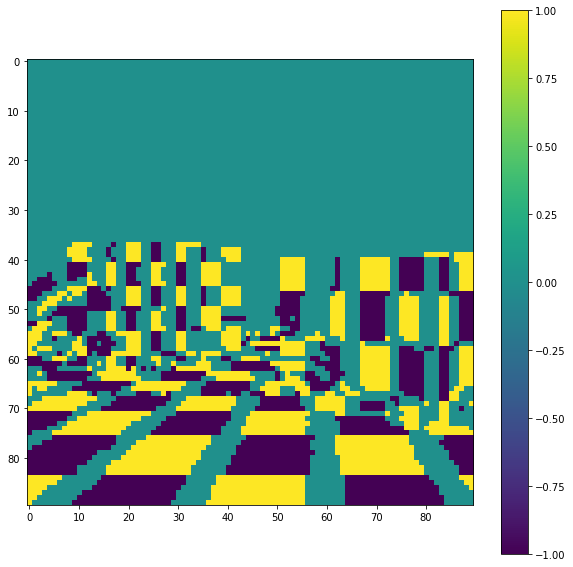

In [26]:
plt.figure(figsize=(10, 10))
m = plt.imshow(input_data.sum(axis=-1), interpolation="none")
plt.colorbar(m)

In [27]:
input_data_time = np.zeros((input_data.shape[0], input_data.shape[1]))
for i in range(input_data.shape[-1]):
    input_data_time = np.abs(input_data[:,:,i]*(i+1) + input_data_time * (input_data[:,:,i] == 0).astype(int))

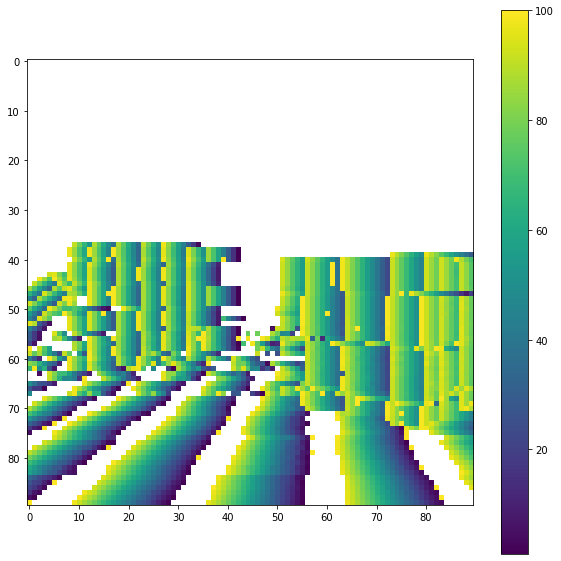

In [28]:
plt.figure(figsize=(10, 10))
img_m = np.ma.masked_where(input_data_time==0, input_data_time)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(m)

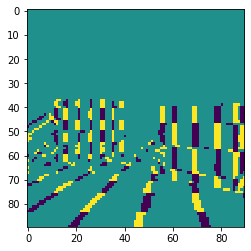

In [29]:
plt.imshow(input_data[:,:,40:60].sum(axis=-1), interpolation="none")

In [30]:
%matplotlib qt
vis.visualize3d(data_d_m, s=50, range=(0.0, 2.5))

In [49]:
d = data_d_m

points = vis._image2pointcloud(d)
calib = np.loadtxt(path + dataset + "calib.txt") / 2
gt = np.loadtxt(path + dataset + "groundtruth.txt")
idx = np.searchsorted(gt[:, 0], t_start)
p = gt[idx]
p[[1, 2]] = p[[2, 1]]
# print(p)

proj = td.project3d(points, calib, p)
proj = proj[np.any(np.logical_not(np.isinf(proj)), axis=1)]

proj = proj[proj[:,1] > -4]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3], cmap="jet", z=1)

o3d.visualization.draw_geometries([pcd])

-3.9763937935155385
-1.6963937691315145
---


In [32]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r", vmin=0.5, vmax=2.5)
# ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [33]:
np.asarray(pcd.points)

array([[-2.35308196, -3.00739385,  1.54781709],
       [-2.33645203, -3.00739385,  1.54781708],
       [-2.3178265 , -3.06439386,  1.58772891],
       ...,
       [-2.06638211, -2.26639374,  0.32651515],
       [-2.08434244, -2.20939374,  0.34514067],
       [-2.07702527, -2.20939374,  0.34514067]])

In [34]:
plt.hist((np.asarray(pcd.colors)[:,2]), 100);

In [35]:
np.asarray(pcd.colors)

array([[1.        , 0.53812636, 0.        ],
       [1.        , 0.53812636, 0.        ],
       [1.        , 0.46550472, 0.        ],
       ...,
       [0.        , 0.        , 0.89215686],
       [0.        , 0.        , 0.92780749],
       [0.        , 0.        , 0.92780749]])

In [36]:
np.max(proj[:,2])

1.9768691571173989

In [37]:
np.min(proj[:,2])

0.1695285629643699

In [38]:
proj = proj[np.any(np.logical_not(np.isinf(proj)), axis=1)]